# NEURAL NETWORK - HYPERPARAMETER  TUNING

## Name: Vishal L
## Reg.no: 20BAI1038

## Importing Necesaary Libraries

In [55]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as px
import plotly.express as ex
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Feature Scaling and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [56]:
# Read the csv file
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploring the Dataset

In [57]:
# Shape of the raw data
print("Shape of Data raw data: {}".format(data.shape))

Shape of Data raw data: (10000, 14)


In [58]:
# Dropping the column which will not make big impact on dependent variables
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace=True)

There are 10000 rows and 14 columns in the raw dataset.

In [59]:
# Stastical analysis of the data
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [60]:
# Detecting the ouliers
def detect_outlier(data):
    outlier = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i - mean)/std
        if np.abs(z_score)>threshold:
            outlier.append(i)
    return outlier

In [61]:
CreditScore_list = data['CreditScore'].tolist()
Balance_list = data['Balance'].tolist()
EstimatedSalary_list = data['EstimatedSalary'].tolist()

In [62]:
CreditScore_outlier = detect_outlier(CreditScore_list)
CreditScore_outlier

[359, 350, 350, 358, 351, 350, 350, 350]

In [63]:
Balance_outlier = detect_outlier(Balance_list)
Balance_outlier

[]

In [64]:
EstimatedSalary_outlier = detect_outlier(EstimatedSalary_list)
EstimatedSalary_outlier

[]

In [65]:
# Shape of Data before removing the outliers
print("Shape of Data before removing outliers: {}".format(data.shape))


Shape of Data before removing outliers: (10000, 11)


In [66]:
# Removing the outliers
data.drop(data[data['CreditScore'] <= 359].index, inplace = True)

In [67]:
#Shape of Data after removing the outliers
print("Shape of Data after removing outliers: {}".format(data.shape))

Shape of Data after removing outliers: (9992, 11)


# Data Preprocessing

In [68]:
# Split the Dataset
X= data.drop(['Exited'], axis = 1)
y = data['Exited']

In [69]:
# Creating dummy variables
Dummies = pd.get_dummies(X[['Geography', 'Gender']],drop_first=True)
X = X.drop(['Geography', 'Gender'], axis = 1)
X = pd.concat([X, Dummies], axis = 1)

In [70]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



In [71]:
# Feature Scaling using standard scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Data Modelling

In [72]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu',input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train, y_train,validation_split=0.33, batch_size = 128, epochs = 100, verbose=0)

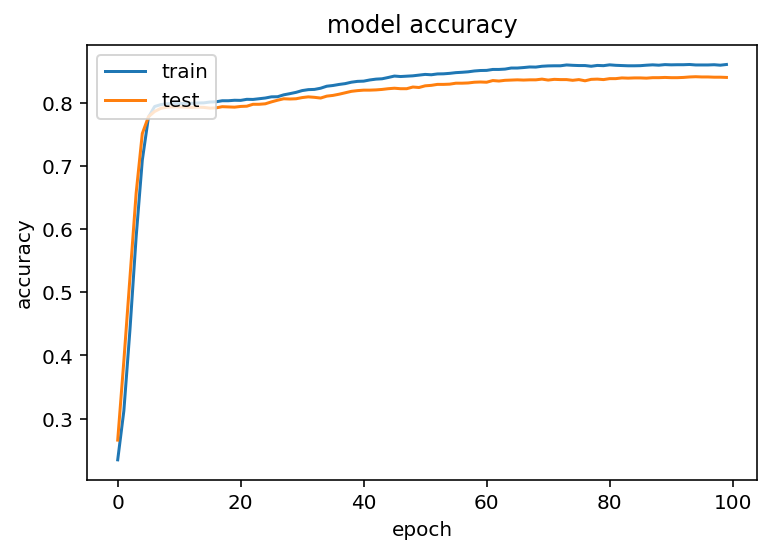

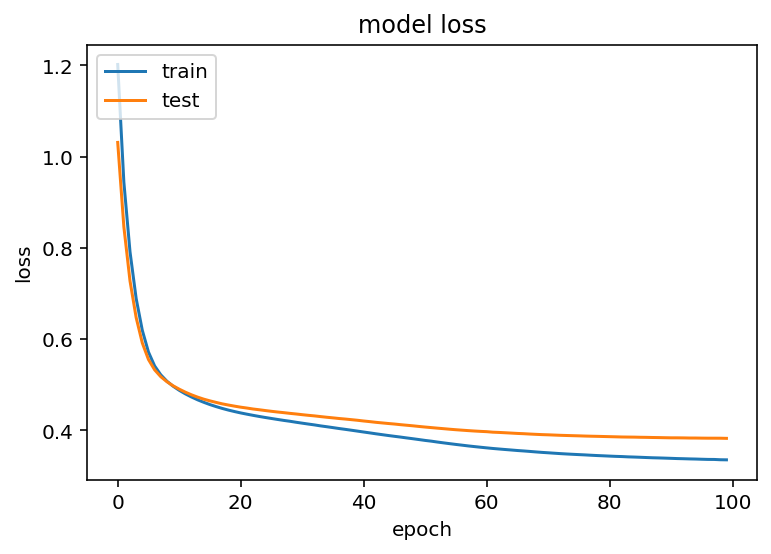

In [73]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the classification report
print(classification_report(y_test, y_pred))

# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Calculate the Accuracy
print(accuracy_score(y_test, y_pred))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1603
           1       0.70      0.44      0.54       396

    accuracy                           0.85      1999
   macro avg       0.79      0.70      0.73      1999
weighted avg       0.84      0.85      0.84      1999

[[1529   74]
 [ 220  176]]
0.8529264632316158


# Hyperparameter Optimization using keras tuner

In [75]:
def build_model(hp):
    
    model = keras.Sequential()
    counter = 0
    
    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        if counter == 0:
            model.add(layers.Dense(hp.Int('units_' + str(i),
                                min_value=8,
                                max_value=128,
                                step=8), kernel_initializer = 'he_uniform', activation='relu',input_dim = 11))
            model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else:
            model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=128,
                                            step=8),
                               activation='relu', kernel_initializer = 'he_uniform'))
            model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        counter+=1
    
    # Adding the output layer
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer = 'glorot_uniform'))
    # Compiling the ANN
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model        

In [78]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    seed=42,
    max_trials=5,
    overwrite=True,
    executions_per_trial=3,
    directory='project4',
    project_name='Churn modelling4')

In [79]:
tuner.search(X_train, y_train, epochs=5, batch_size=128, 
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 08s]
val_accuracy: 0.8125729362169901

Best val_accuracy So Far: 0.8590962290763855
Total elapsed time: 00h 00m 52s
INFO:tensorflow:Oracle triggered exit


### So after running 5 trials , with 3 executions per trial , we got the accuracy to be 85.909% which was increased by 4% from 81.257% by hyperparameter tuning.

In [80]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 2,
 'units_0': 64,
 'dropout0': 0.5,
 'learning_rate': 0.01,
 'units_1': 104,
 'dropout1': 0.3,
 'units_2': 56,
 'dropout2': 0.2,
 'units_3': 32,
 'dropout3': 0.2,
 'units_4': 56,
 'dropout4': 0.8,
 'units_5': 72,
 'dropout5': 0.9,
 'units_6': 56,
 'dropout6': 0.4,
 'units_7': 48,
 'dropout7': 0.7,
 'units_8': 24,
 'dropout8': 0.4}

In [81]:
model = tuner.get_best_models(num_models=1)[0]

In [83]:
model.fit(X_train, y_train, epochs=200, initial_epoch=6, validation_data=(X_test,y_test), verbose = 0)

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 104)               6760      
                                                                 
 dropout_1 (Dropout)         (None, 104)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 105       
                                                                 
Total params: 7,633
Trainable params: 7,633
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Evaluate the best model.
loss, accuracy = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.4503 - accuracy: 0.8524


## After performing hyperparameter tuning using keras tuner accuracy, somewhat increased to 0.8590 from 0.8669. 